In [1]:
import sys
sys.path.append('/NDDepth/src')

In [2]:
from PIL import Image
import torch
import tqdm
from torch.utils.data import DataLoader
import torch.nn.functional as F

import matplotlib.pyplot as plt
from model import Model, ModelConfig
from dataloader.BaseDataloader import BaseImageDataset
from dataloader.NYUDataloader import NYUImageData
from DN_to_distance import DN_to_distance

from loss import silog_loss, get_metrics

torch.manual_seed(42)

device = "cuda"

In [3]:
TRAIN_BATCH_SIZE = 6

train_dataset = BaseImageDataset('train', NYUImageData, '/scratchdata/nyu_depth_v2/sync', '/scratchdata/nyu_depth_v2/sync/train.csv')
train_dataloader = DataLoader(train_dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=True, pin_memory=True)

config =  ModelConfig("tiny07")
config.batch_size = TRAIN_BATCH_SIZE
config.height = 480//4
config.width = 640//4
model = Model(config).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [4]:
model.train()
silog_criterion = silog_loss(variance_focus=0.85)
dn_to_distance = DN_to_distance(config.batch_size, config.height * 4, config.width * 4).to(device)
for i, x in enumerate(tqdm.tqdm(train_dataloader)):
    
    for k in x.keys():
        x[k] = x[k].to(device)

    d1_list, u1, d2_list, u2, norm_est, dist_est = model(x)

    # Post Processing

    gt = x["depth_values"]
    normal_gt = torch.stack([x["normal_values"][:, 0], x["normal_values"][:, 2], x["normal_values"][:, 1]], 1).to(device)
    normal_gt_norm = F.normalize(normal_gt, dim=1, p=2).to(device)
    distance_gt = dn_to_distance(gt, normal_gt_norm, x["camera_intrinsics"])

    for i in range(len(d1_list)): d1_list[i] = F.interpolate(d1_list[i], size=gt.shape[2:], mode='bilinear', align_corners=False)
    for i in range(len(d2_list)): d2_list[i] = F.interpolate(d2_list[i], size=gt.shape[2:], mode='bilinear', align_corners=False)
    u1 = F.interpolate(u1, size=gt.shape[2:], mode='bilinear', align_corners=False)
    u2 = F.interpolate(u2, size=gt.shape[2:], mode='bilinear', align_corners=False)

    # Depth Loss

    loss_depth1_0 = silog_criterion(d1_list[0], gt, x["mask"])
    loss_depth2_0 = silog_criterion(d2_list[0], gt, x["mask"])

    loss_depth1 = 0
    loss_depth2 = 0
    weights_sum = 0
    for i in range(len(d1_list) - 1):
        loss_depth1 += (0.85**(len(d1_list)-i-2)) * silog_criterion(d1_list[i + 1], gt, x["mask"])
        loss_depth2 += (0.85**(len(d2_list)-i-2)) * silog_criterion(d2_list[i + 1], gt, x["mask"])
        weights_sum += 0.85**(len(d1_list)-i-2)
    
    loss_depth = (loss_depth1 + loss_depth2) / weights_sum + loss_depth1_0 + loss_depth2_0 
    
    # Uncertainty Loss

    uncer1_gt = torch.exp(-5 * torch.abs(gt - d1_list[0].detach()) / (gt + d1_list[0].detach() + 1e-7))
    uncer2_gt = torch.exp(-5 * torch.abs(gt - d2_list[0].detach()) / (gt + d2_list[0].detach() + 1e-7))
    
    loss_uncer1 = torch.abs(u1-uncer1_gt)[x["mask"]].mean()
    loss_uncer2 = torch.abs(u2-uncer2_gt)[x["mask"]].mean()

    loss_uncer = loss_uncer1 + loss_uncer2


    loss_normal = 5 * ((1 - (normal_gt_norm * norm_est).sum(1, keepdim=True)) * x["mask"]).sum() / (x["mask"] + 1e-7).sum()
    loss_distance = 0.25 * torch.abs(distance_gt[x["mask"]]- distance_est[x["mask"]]).mean()

    print(loss_depth1)
    print(loss_depth2)
    print(loss_depth1_0)
    print(loss_depth2_0)
    print(loss_uncer1)
    print(loss_uncer2)

    loss = (loss_depth1 + loss_depth2) / weights_sum + loss_depth1_0 + loss_depth2_0 + loss_uncer1 + loss_uncer2
    loss = loss.mean()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    break

  0%|          | 0/4853 [00:00<?, ?it/s]

torch.Size([6, 3, 307200])
torch.Size([6, 1, 480, 640])
tensor(11.7211, device='cuda:0', grad_fn=<AddBackward0>)
tensor(10.7003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(4.5250, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(3.7610, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.4868, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.5329, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 0/4853 [00:02<?, ?it/s]


In [11]:
test = torch.tensor([[1,2,3],[4,5,6]])
mask = torch.tensor([[True,True,False],[False,False,True]],dtype=torch.bool)
print(test*mask)

tensor([[1, 2, 0],
        [0, 0, 6]])


In [5]:
for k in x.keys():
    x[k] = x[k].cpu()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


torch.Size([6, 3, 480, 640])
tensor(1.)


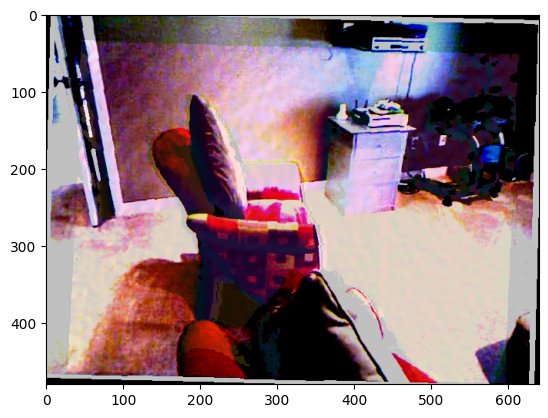

In [6]:
print(x["normal_values"].shape)
print(x["normal_values"][0].max())

plt.imshow(x["pixel_values"][0].squeeze().permute(1, 2, 0))
plt.imshow(x["normal_values"][0].squeeze().permute(1, 2, 0),alpha=0.25)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


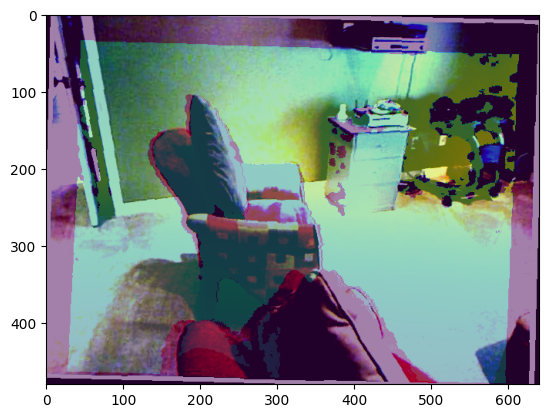

In [7]:
plt.imshow(x["pixel_values"][0].squeeze().permute(1, 2, 0))
plt.imshow(x["depth_values"][0].squeeze(), alpha=0.5)